<a href="https://colab.research.google.com/github/Mahendhar-Saratha/CITE-seq/blob/main/Kaggle_2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kaggle Challenge # 2**

Author : **M**ahendhar Saratha

CITE-seq measures gene and protein expression in single cells, enabling analysis of cell type markers and gene expression correlations. It uses Antibody-Derived Tags for protein and RNA-sequencing for gene expression. The challenge is to predict 25 protein expressions in 1000 cells from gene expression data of 639 genes, using a dataset of 4000 cells with complete protein and gene information. This prediction task requires leveraging training data, including test RNA data, for accurate protein expression forecasts and we used two methods Ordinary Least Squares regression and Non-negative matrix factorization with L2 regularization

In [ ]:
from google.colab import drive

# Mounting Google Drive to the Colab environment
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import Statements**

Importing Numpy and pandas python libraries and sklearn library for Non-negative matrix factorization analysis

**training_set_adt.csv**: Contains protein expression levels for 25 proteins across various training samples. Each row represents a protein, and each column (starting from the second column) represents a sample.

**training_set_rna.csv**: Consists of gene expression levels for 639 genes across the same set of training samples as in the ADT dataset. Each row represents a gene, and each column represents a sample.

**test_set_rna.csv**: Contains gene expression levels for the same 639 genes across a set of test samples. Each row represents a gene, and each column represents a sample.

In [ ]:
import numpy as np
import pandas as pd

## Below Imports are for NMF implementation

from scipy.interpolate import make_interp_spline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

## This is to avoid some warning messages in the output to show correct result
import warnings
warnings.filterwarnings('ignore')

# Row number checker for final data writting
global row_number
row_number=1

# Loading the datasets
training_set_adt = pd.read_csv('/content/drive/MyDrive/Kaggle2/training_set_adt.csv')
training_set_rna = pd.read_csv('/content/drive/MyDrive/Kaggle2/training_set_rna.csv')
test_set_rna = pd.read_csv('/content/drive/MyDrive/Kaggle2/test_set_rna.csv')

# Dropping Unnamed column and Transposing the data
X_train = training_set_rna.drop(columns='Unnamed: 0').values.T
y_train = training_set_adt.drop(columns='Unnamed: 0').values.T
X_test = test_set_rna.drop(columns='Unnamed: 0').values.T

Missing Value Analysis : There are no missing values for the datasets provided

In [ ]:
missing_test_rna = test_set_rna.isnull().sum().sum()
missing_training_adt = training_set_adt.isnull().sum().sum()
missing_training_rna = training_set_rna.isnull().sum().sum()

print("Missing values in missing_test_rna:", missing_test_rna)
print("Missing values in missing_training_adt:", missing_training_adt)
print("Missing values in missing_training_rna:", missing_training_rna)

Missing values in missing_test_rna: 0
Missing values in missing_training_adt: 0
Missing values in missing_training_rna: 0


**2. Implementation using Ordinary Least Squares method- Linear Regression**

In this analysis, we used Ordinary Least Squares (OLS) regression to predict protein expression profiles from gene expression data. We started by loading and preprocessing the training and test datasets, not focusing on normalization as it is already log normalized and feature selection to identify highly variable genes. We transposed the datasets to align samples and features appropriately for regression analysis. A OLS method was employed to conclude the co-efficients of the RNA data, selecting genes with the most variability. For each of the 25 proteins, an OLS model was fitted using the training RNA data as predictors. These models were then used to predict the protein expression levels in the test RNA dataset. This approach allowed us to efficiently leverage the RNA data to estimate protein expression levels, offering a robust method for multi-omics data integration.

In [ ]:
# Ordinary Least Squares function
def ordinary_least_squares(X, y):
    X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
    X_Trans=X_with_intercept.T
    final = np.linalg.pinv(X_Trans.dot(X_with_intercept)).dot(X_Trans).dot(y)
    return final

# Saving the predictions to a CSV file
def finalCSVWritting(final_element):
    global row_number
    columns=['Id','Expected']
    outFrame = pd.DataFrame([columns])
    outFrame.to_csv('sumbission.csv', mode='a', index=False, header=False)
    for i in final_element:
        for value in final_element[i]:
            outFrame=pd.DataFrame([{'Id':'ID_'+str(row_number), 'Expected': value}])
            outFrame.to_csv('sumbission.csv', mode='a', index=False, header=False)
            row_number+=1

# Coefficients using Ordinary Least Squares
out_data = ordinary_least_squares(X_train, y_train)

# Adding the intercept term to X_test and predicting on the test set
X_test_with_intercept = np.hstack([np.ones((X_test.shape[0], 1)), X_test])
y_test_pred = X_test_with_intercept.dot(out_data)

# Converting Final Prediction to Data Frame
predicted_adt_df = pd.DataFrame(y_test_pred.T, columns=test_set_rna.columns[1:])

# Saving the predictions to a CSV file
finalCSVWritting(predicted_adt_df)

**3. Plotting Linear regression line**

Here we plotted the linear regression line for above code by taking 6 pair of predicted outputs

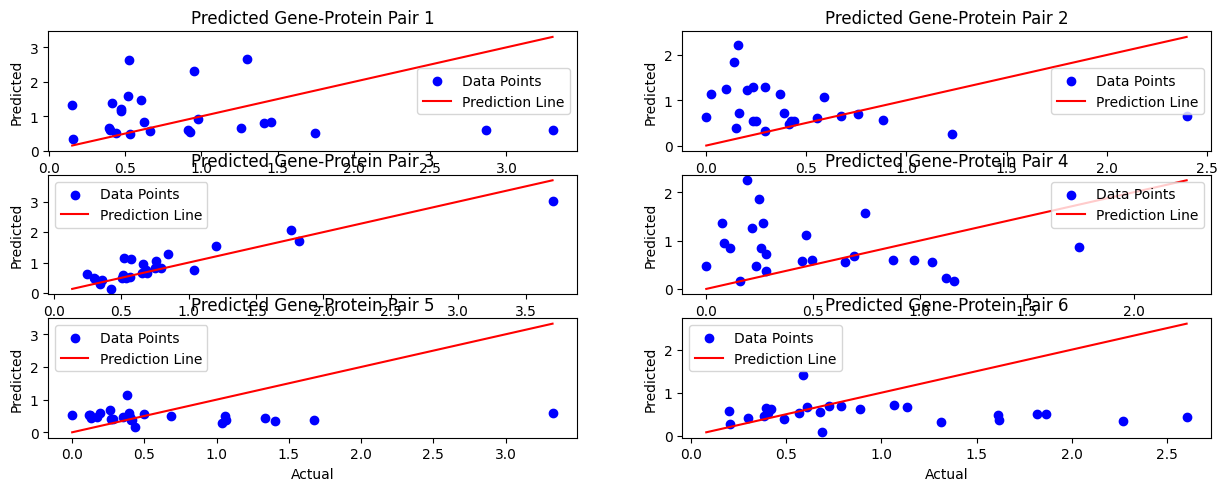

In [ ]:
def plot_actual_vs_predicted(actual, predicted, title_prefix=''):
    plt.figure(figsize=(15, 9))
    for i in range(6):
        plt.subplot(5, 2, i+1)
        plt.scatter(actual[i, :], predicted[i, :], color='blue', label='Data Points')
        #Determining Min and max points for the line
        min_val = min(actual[i, :].min(), predicted[i, :].min())
        max_val = max(actual[i, :].max(), predicted[i, :].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='red', label='Prediction Line')
        plt.title(f'{title_prefix} Gene-Protein Pair {i+1}')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
    plt.show()
plot_actual_vs_predicted(y_train[:6, :], y_test_pred[:6, :], title_prefix='Predicted')

**4. Using Non-negative Matrix Factorization (NMF) and Ridge Regression**

The Non-negative Matrix Factorization (NMF) approach was used to uncover latent patterns in RNA data for predicting protein expression. By decomposing the training RNA data into basis vectors (components) and coefficients. The test RNA data was then transformed into 25 Component vector as same as our final prediction, indicating its relationship with the identified components. However, directly predicting protein expression (ADT data) from these components proved challenging due to the unsupervised nature of NMF, which does not inherently map to ADT levels. Additionally we applied Ridge regression to predict protein levels. This approach emphasizes the complexity of bridging unsupervised feature extraction with supervised prediction tasks in multi-omics data analysis.

In [ ]:
# Initializations and fitting NMF model to the RNA training data
nmf_model = NMF(n_components=25, max_iter=1000)
W_train_rna = nmf_model.fit_transform(X_train)
W_test_rna = nmf_model.transform(X_test)

# Training a MultiOutputRegressor model
model = MultiOutputRegressor(Ridge(alpha=1.0))
model.fit(W_train_rna, y_train)

# Predicting the ADT test data using the trained model and NMF-transformed RNA test data
Y_pred_adt_test = model.predict(W_test_rna)

# Converting the predicted ADT test data to a DataFrame
predicted_adt_test_df = pd.DataFrame(Y_pred_adt_test.T, columns=test_set_rna.columns[1:])

# Saving data to final CSV File
finalCSVWritting(predicted_adt_test_df)

**5. Cross Validations for best hyperparameter for Maximum Iterations using NMF**


The cross-validation approach integrates Non-negative Matrix Factorization (NMF) for dimensionality reduction with a Ridge regression model to predict protein expression levels from gene expression data. This process evaluated to find out best max_iter value, ensuring seamless transformation and prediction across data folds. KFold cross-validation assesses the model's performance, using  mean squared error as the metric to evaluate the prediction accuracy systematically. The integration of NMF and Ridge regression within a cross-validation framework provides a robust evaluation of the model's predictive capability, allowing for parameter tuning and optimization based on the cross-validation results. This method effectively combines unsupervised and supervised learning techniques to enhance prediction reliability and model performance

In [ ]:
#max_iter_values = [50, 100, 200, 300, 400, 500,600,700,1000,1500,2000]
max_iter_values = [50, 100, 200, 300, 400, 500,600,700,1000]
# 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
avg_reconstruction_errors = {mi: [] for mi in max_iter_values}

for max_iter in max_iter_values:
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]

        # Fitting the NMF model on the training fold
        nmf_model = NMF(n_components=y_train.shape[1], init='random', random_state=0, max_iter=max_iter)
        W_train_fold = nmf_model.fit_transform(X_train_fold)
        H = nmf_model.components_

        # Transforming the validation fold separately
        W_val_fold = nmf_model.transform(X_val_fold)

        # Reconstructing the validation fold
        X_val_reconstructed = np.dot(W_val_fold, H)

        # Calculating MSE
        reconstruction_error = mean_squared_error(X_val_fold, X_val_reconstructed)
        # appending data to final dictionary
        avg_reconstruction_errors[max_iter].append(reconstruction_error)

# Calculating the average reconstruction error for each max_iter value
avg_reconstruction_errors_mean = {mi: np.mean(errors) for mi, errors in avg_reconstruction_errors.items()}

# Finding the max_iter value with the lowest average reconstruction error
best_max_iter = min(avg_reconstruction_errors, key=avg_reconstruction_errors.get)

print("Best Maximun Iteration Value is :", best_max_iter)
print("Average Reconstruction Errors for each Maximum Iterations are:", avg_reconstruction_errors)


Best Maximun Iteration Value is : 700
Average Reconstruction Errors for each Maximum Iterations are: {50: [0.5883611377783087, 0.5927819692357357, 0.5954688949734163, 0.5858330767472916, 0.5884775509241025], 100: [0.5870172154096, 0.5907777180928279, 0.594221178241002, 0.5842035853412125, 0.5870206286963096], 200: [0.5865308752815196, 0.5900510080628979, 0.593232486404475, 0.5835588492353629, 0.5866113381802966], 300: [0.5861088285077307, 0.5898624510908891, 0.5931671605866911, 0.5834997586927572, 0.5865355337214431], 400: [0.5858727443763009, 0.5898127389235001, 0.5931420774645337, 0.5833756587952311, 0.5864946250791846], 500: [0.585724134553907, 0.589825850660044, 0.5930768432985954, 0.5833651786468582, 0.5865077143726393], 600: [0.5855964129881035, 0.5898531415338234, 0.5929788758905072, 0.5833807669973058, 0.5865163473951108], 700: [0.5855454352803063, 0.5898611469794819, 0.5928952551036548, 0.5834054108404605, 0.5865127639385007], 1000: [0.5856149348846281, 0.5898683554287241, 0.5

**6. Plotting the results for Raw Data**

Plotting above maximum iterations data

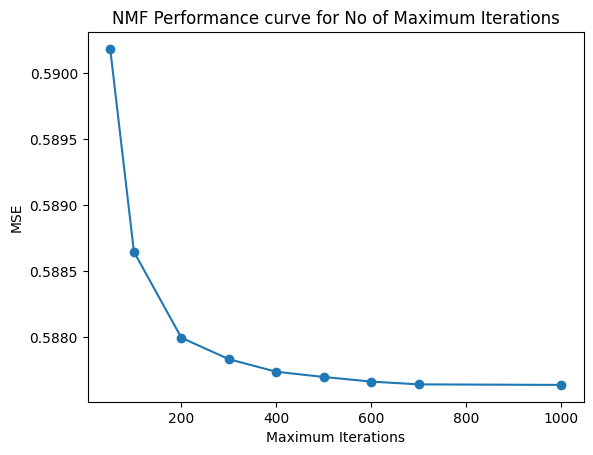

In [ ]:
x=np.array(list(avg_reconstruction_errors_mean.keys()))
y=np.array(list(avg_reconstruction_errors_mean.values()))

# Plotting the Graph
plt.scatter(x, y)
plt.plot(x, y)
plt.title("NMF Performance curve for No of Maximum Iterations")
plt.xlabel("Maximum Iterations")
plt.ylabel("MSE")
plt.show()

**7. Conclusion**

In our Analysis, we discovered that Ordinary Least Squares (OLS) regression, despite its simplicity, outperformed a more complex method involving Non-negative Matrix Factorization (NMF) followed by regression for predicting protein expression from gene expression data. This finding highlights the importance of direct feature utilization, as OLS leverages the full set of gene expressions without discarding potentially predictive information through dimensionality reduction. The superior performance of OLS suggests that the linear relationships present in the full-dimensional space are crucial for accurate predictions, underscoring the value of simplicity and directness in certain predictive modelling tasks. While dimensionality reduction techniques like NMF aim to simplify the data and highlight underlying patterns, our results indicate that such approaches might inadvertently remove essential information, leading to suboptimal predictions. This outcome emphasizes that the choice of modelling technique should be closely aligned with the data's characteristics and the specific objectives of the prediction task. Ultimately, our project underscores the principle that more complex models do not always lead to better predictions, especially when the original features directly contribute to the outcome of interest.

Adding to our findings, our participation in the Kaggle competition resulted in securing a Pearson Correlation Coefficient score of 0.80225 using OLS and 0.6341 using NMF. This score signifies the model's proficiency in capturing the linear relationship between the actual and predicted protein expression levels, highlighting its precision. Approaching a value of 1, this correlation score effectively demonstrates the model's success in generating predictions that closely match the real observed data. This high degree of correlation serves as a robust endorsement of our modelling approach, clearly illustrating its capacity to accurately reflect the intricate dynamics between gene expressions and protein expressions.